#"Will It Learn?" - Mazes
Will a simple convolution network learn to solve a maze? Let's make this hard and give it only pixels. Let's see if we can make it produce a single image that draws out the solution path.

###First we will create some functions to create a random maze:

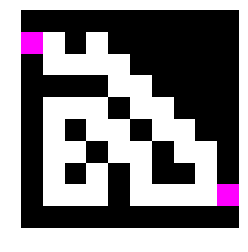

In [1]:
#This is a code cell. Click on the cell to make it active. 
#Then click on the left corner arrow in a circle button to run it. Or use the keyboard shortcut ctlr+enter.
import numpy as np
from PIL import Image, ImageDraw
import random
import copy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

#maze dimensions, also image dimensions
w = 10
h = 10
img_shape = (h,w,3)
clear = 1.0
filled = 0.0

def set_cell(cells, coord, val=clear):
  cells[coord[0]][coord[1]] = val

def get_cell(cells, coord):
  return cells[coord[0]][coord[1]]

def add_vec(vec1, vec2):
  return (vec1[0] + vec2[0], vec1[1] + vec2[1])

def coord_out_of_bounds(coord, limits):
  if coord[0] < 0 or coord[0] >= limits[0]:
    return True
  if coord[1] < 0 or coord[1] >= limits[1]:
    return True
  return False

def check_cell(cells, coord, limits):
  return not coord_out_of_bounds(coord, limits) and\
      get_cell(cells, coord) == filled

def check_turn_cell(cells, coord, limits):
  return coord_out_of_bounds(coord, limits) or\
      get_cell(cells, coord) == filled

def find_random_clear_move(cells, current_pos, limits):
  done = False
  moves = [(1, 0), (-1, 0), (0, 1), (0, -1)]
  ortho_r = [(0, 1), (0, -1), (1, 0), (-1, 0)]
  ortho_l = [(0, -1), (0, 1), (-1, 0), (1, 0)]
  possible_moves = []
  for move, right, left in zip(moves, ortho_r, ortho_l):
    coord = add_vec(current_pos, move)
    next_coord = add_vec(coord, move)
    r_coord = add_vec(coord, right)
    l_coord = add_vec(coord, left)
    
    if check_cell(cells, coord, limits) and\
      check_cell(cells, next_coord, limits) and\
      check_turn_cell(cells, r_coord, limits) and\
      check_turn_cell(cells, l_coord, limits):
      possible_moves.append(coord)
      
  move = None
  done = len(possible_moves) == 0
  
  if not done:
    iMove = random.randint(0, len(possible_moves) - 1)
    move = possible_moves[iMove]
  
  return move, done

def random_maze(dimx, dimy):
  #first solid fill
  cells=np.zeros((dimx, dimy))
  
  #first random tunnel
  start = (1, 1)
  clear_cells = [start]
  set_cell(cells, start, clear)
  done = False
  current_pos = start
  limits = (dimx, dimy)
  
  while not done:
    current_pos, done = find_random_clear_move(cells, current_pos, limits)
    if not done:
      set_cell(cells, current_pos, clear)
      clear_cells.append(current_pos)
      
  #now tunel some offshoots
  while len(clear_cells) > 0:
    done = False
    iSt = random.randint(0, len(clear_cells) - 1)
    current_pos = clear_cells.pop(iSt)
    while not done:
      current_pos, done = find_random_clear_move(cells, current_pos, limits)
      if not done:
        set_cell(cells, current_pos, clear)
        clear_cells.append(current_pos)
      
  #now clear the start, end
  set_cell(cells, (1, 0), clear)
  end = (dimx-2, dimy-1)
  d_end = (0, -1)
  while check_cell(cells, end, limits):
    set_cell(cells, end, clear)
    end = add_vec(end, d_end)
    
  #return cell matrix, start, end
  return cells, (1, 0), (dimx-2, dimy-1)

def img_maze(img_shape, cells, start, end):
  w = img_shape[1]
  h = img_shape[0]
  three_planes = np.ones([w, h, 3], dtype=np.dtype('B'))
  three_planes[...,0] = cells * 255
  three_planes[...,1] = cells * 255
  three_planes[...,2] = cells * 255
  
  three_planes[start[0]][start[1]][1] = 1
  three_planes[end[0]][end[1]][1] = 1
  
  img = Image.fromarray(three_planes)
  
  return img
    
cells, start, end = random_maze(img_shape[0], img_shape[1])
img = img_maze(img_shape, cells, start, end)
plt.axis('off')
plt.imshow(img)
plt.show()

#This should show an image of a random maze. Pink dots at start and end.

###Now let's find the solution via A*

In [3]:
!pip3 install astar

random maze


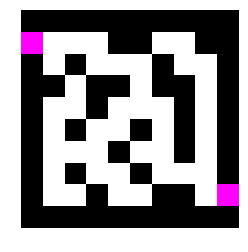

solution


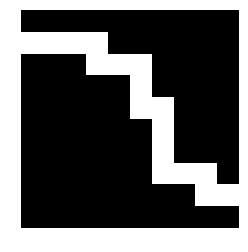

In [5]:
from astar import AStar
import math

class MazeSolver(AStar):
    """ from https://github.com/jrialland/python-astar/blob/master/src/test/maze/maze.py
        a 'node' is just a (x,y) tuple that represents a reachable position"""

    def __init__(self, cells):
        self.cells = cells
        self.width = cells.shape[0]
        self.height = cells.shape[1]
        self.searched = []

    def heuristic_cost_estimate(self, n1, n2):
        """computes the 'direct' distance between two (x,y) tuples"""
        (x1, y1) = n1
        (x2, y2) = n2
        return math.hypot(x2 - x1, y2 - y1)

    def distance_between(self, n1, n2):
        """this method always returns 1, as two 'neighbors' are always adajcent"""
        return 1
      
    def add_searched(self, nodes):
        for node in nodes:
          if not node in self.searched:
            self.searched.append(node)

    def neighbors(self, node):
        """ for a given coordinate in the maze, returns up to 4 adjacent(north,east,south,west)
            nodes that can be reached (=any adjacent coordinate that is not a wall)
        """
        x, y = node
        nodes = [(nx, ny) for nx, ny in[(x, y - 1), (x, y + 1), (x - 1, y), (x + 1, y)]\
               if 0 <= nx < self.width and 0 <= ny < self.height and self.cells[nx][ny] == clear]
        
        new_nodes = []
        for node in nodes:
          if not node in self.searched:
            new_nodes.append(node)
            
        self.add_searched(new_nodes)
        self.add_searched([(x, y)])
        return new_nodes

def find_maze_sln(cells, start, end):
  solver = MazeSolver(cells)
  ret = solver.astar(start, end)
  soln = []
  if ret:
    soln = list(ret)
  return soln

def img_soln(img_shape, cells, soln):
  w = img_shape[1]
  h = img_shape[0]
  img = np.zeros([w, h], dtype=np.dtype('B'))
   
  for coord in soln:
    img[coord[0]][coord[1]] = 255
   
  return img

cells, start, end = random_maze(img_shape[0], img_shape[1])

print("random maze")
img = img_maze(img_shape, cells, start, end)
plt.axis('off')
plt.imshow(img)
plt.show()

soln = find_maze_sln(cells, start, end)

print("solution")
img = img_soln(img_shape, cells, soln)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()
  
#This should show a random maze and the solution path based on our search algorithm.
#We will use this data to train our NN to produce the same path outputs, given the maze.

##Next we will create some routines to get input, label pairs

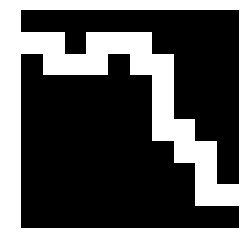

In [6]:
from random import shuffle, randint
import numpy as np

def get_data(image_shape):
  cells, start, end = random_maze(img_shape[0], img_shape[1])
  img_m = img_maze(img_shape, cells, start, end)
  soln = find_maze_sln(cells, start, end)
  img_s = img_soln(img_shape, cells, soln)
  return np.array(img_m) / 255.0, np.array(img_s) / 255.0

img, label = get_data(img_shape)
plt.axis('off')
plt.imshow(label, cmap='gray')
plt.show()


##What do you think?
Will this somewhat simple network accomplish the task of learning to solve a random maze?


Let's find out...

First let's make sure you are using the GPU. Run the cell bellow to double check:

In [0]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#if you see something like '/device:GPU:0' then the gpu accelerated learning will be enabled. if not, cpu will work, just slower.

##Our Neural Network

Here's what our network will look like. Pretty straight foward, 6 layers of convolutions. 64 filters per layer. A 3x3 kernel used in each. With relu activation in each. In this case we will use same padding and no stride to produce an output that matches our input image size.

We will use mean squared error for our loss term. This should give it a chance to know how well it's going and improve.


In [7]:
#Let's define a pretty straight forward conv neural network. It will have about 200K params, given the input image dimension of 24 x 60
import keras
from keras.layers import Flatten, Conv2D, Dense
from keras import losses

img = keras.Input(shape=img_shape)
img_rows = img_shape[0]
img_cols = img_shape[0]

padding="same"
kernel_dim = (3, 3)
num_filters = 64
num_layers = 6

x = img
for i in range(num_layers):
  x = Conv2D(num_filters, kernel_dim, strides=(1,1), padding=padding, activation="relu")(x)
x = Conv2D(1, kernel_dim, strides=(1,1), padding=padding, activation="relu")(x)

model = keras.Model(img, x)

model.compile(optimizer="adam", loss="mse", metrics=['acc'])

print(model.summary())

Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.4 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 432, got 412
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 56, got 52
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 10, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        36928     
__________

###Now let's start the training:

our benchmark maze:


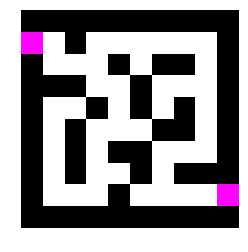

our benchmark prediction:


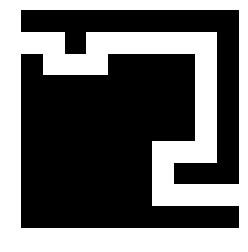

Epoch 1/4


In [ ]:
# Here's function that will generate a numpy array of images and moves for our NN to train on
def generator(img_shape, batch_size):
  while True:
    X = []
    y = []
    for i in range(batch_size):
      img, label= get_data(img_shape)
      X.append(img)
      y.append(label)
    yield np.array(X), np.array(y).reshape(batch_size, h, w, 1)
    
  
pred_img, label = get_data(img_shape)

print("our benchmark maze:")
plt.axis('off')
plt.imshow(pred_img)
plt.show()

print("our benchmark prediction:")
plt.axis('off')
plt.imshow(label, cmap='gray')
plt.show()

def plot_callback(batch, logs):
  res = model.predict(pred_img[None, :, :, :])
  plt.axis('off')
  pred = res[0].reshape(w, h)
  plt.imshow(pred, cmap='gray')
  plt.show()

callbacks = [keras.callbacks.LambdaCallback(on_epoch_end=plot_callback)]
    
#Now let's start the training.
batch_size = 32
steps_per_epoch = 256
epochs = 4

train_gen = generator(img_shape, batch_size)

model.fit_generator(train_gen, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    callbacks=callbacks,
                    verbose=1)


In [ ]:
#Now let's create a new image and see how it does.
#Run this code cell multiple times to get a feeling about how it handles different cases.

img, label = get_data(img_shape)
res = model.predict(img[None, :, :, :])
print(res.shape)

print("Maze:")
plt.axis('off')
plt.imshow(img)
plt.show()

print("Predicts:")
plt.axis('off')
pred = res[0].reshape(h, w)
#pred = pred > 0.2 #this will produce binary map
plt.imshow(pred, cmap='gray')
plt.show()

print("Answer:")

plt.axis('off')
plt.imshow(label, cmap='gray')
plt.show()

#So What's Your Verdict?
###Do you think this learned to solve the maze?

I had an intuition that this would be possible. But it was still fun to see it work. Originally my maze was way too complex, and couldn't be learned in a short time. Play with the dimensions ( w, h) of the maze and see how it affects the ability to solve.

#Further thought..

Try to adjust the number of layers in the model and see where things go badly. At 4 layers it was making quite a few mistakes. 8 layers works well and can handle larger ( 15, 15) mazes but requires a lot more time to train to ~98% accuracy.

I did notice that even at 96% accuracy there were probably too many mistakes to call this 'solved'. If it were to be useful it really needed to be at @99%. I threw in the predict preview at each epoch end to see how it's improving. I like this a lot.

It's interesting to note which shapes it's less confident with. Based on the white intensity you can see where it's less sure. It tends to be most sure near the entrance and exits, which makes sense given how they are the same. It also has to build outward from those points of confidence to the center, less confident area.

Also intersting to note is that the entire maze is solved 'at once' and not through iterative path exploration. But humans kind of do the same thing for mazes this small. I'd like to see a NN that can solve a maze with only a small window into the entire maze, and thus forced to explore and backtrack. If you are curious too, checkout parts 2, 3, and 4.


[Will It Learn? - S01E05 : Mazes, Part II](https://drive.google.com/open?id=1C1eutM_qIBsVrPwtu4xqfJZYQxssqixz)

[Will It Learn? - S01E05 : Mazes, Part III](https://drive.google.com/open?id=1mRwnRlfEYhd8U5RqK4Gp4sMQBSM97kFh)

[Will It Learn? - S01E05 : Mazes, Part IV](https://drive.google.com/open?id=15gC53CRw9vaPQOheIzUPi7YLpxKdWnbG)

#Episodes Links:

[Will It Learn? - S01E01 Circle Count](https://drive.google.com/open?id=11EiFFa-imh5MNEPJZuqgqJAwLYHhP3gG)

[Will It Learn? - S01E02 Tic Tace Toe](https://drive.google.com/open?id=1PKosDR9wcgPaF2-BYMSZiu2nW03COxma)

[Will It Learn? - S01E03 : Shell Game](https://drive.google.com/open?id=163iv-LaidgxiU3tT_RcLCT_K1HOdagMu)

[Will It Learn? - S01E04 : Word Jumble](https://drive.google.com/open?id=19ENSHOC-TEyDqZ-_47QhSHHxhUAuDEoA)

[Will It Learn? - S01E05 : Mazes](https://drive.google.com/open?id=1qdYWNwrmYAtFsayzoxPuuGAE1RTKt1ia)

